
# Домашнее задание: табличный датасет из `polinaeterna/tabular-benchmark`


In [1]:

!pip -q install datasets scikit-learn matplotlib seaborn pandas numpy

from datasets import load_dataset
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, classification_report, ConfusionMatrixDisplay

sns.set_theme(context="talk", style="whitegrid")


/Users/vdgerman/cloud/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 1. Выбор и загрузка датасета

Используем коллекцию `polinaeterna/tabular-benchmark`

Каждая строка — участок местности в национальном лесу (Roosevelt National Forest, Колорадо, США).

Целевая переменная class — тип лесного покрова (класс леса), многоклассовая классификация.

Признаки описывают рельеф и окружение точки:

* Elevation — высота над уровнем моря.
* Aspect, Slope — экспозиция склона и крутизна.
* Разные расстояния: до водоёмов (Horizontal/Vertical_Distance_To_Hydrology), дорог (Horizontal_Distance_To_Roadways), точек пожаров (Horizontal_Distance_To_Fire_Points).
* Освещённость склона в разное время дня: Hillshade_9am, Hillshade_Noon, Hillshade_3pm.
* Wilderness_Area1–4 — принадлежность к определённой дикой зоне.
* Soil_Type1–40 — тип почвы (one-hot кодирование).

In [4]:
benchmark = load_dataset("polinaeterna/tabular-benchmark", "clf_cat_covertype")
print(benchmark)
print("Доступные сабсеты:", benchmark.keys())

DatasetDict({
    train: Dataset({
        features: ['Elevation', 'Aspect', 'Slope', 'Horizontal_Distance_To_Hydrology', 'Vertical_Distance_To_Hydrology', 'Horizontal_Distance_To_Roadways', 'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm', 'Horizontal_Distance_To_Fire_Points', 'Wilderness_Area1', 'Wilderness_Area2', 'Wilderness_Area3', 'Wilderness_Area4', 'Soil_Type1', 'Soil_Type2', 'Soil_Type3', 'Soil_Type4', 'Soil_Type5', 'Soil_Type6', 'Soil_Type7', 'Soil_Type8', 'Soil_Type9', 'Soil_Type10', 'Soil_Type11', 'Soil_Type12', 'Soil_Type13', 'Soil_Type14', 'Soil_Type15', 'Soil_Type16', 'Soil_Type17', 'Soil_Type18', 'Soil_Type19', 'Soil_Type20', 'Soil_Type21', 'Soil_Type22', 'Soil_Type23', 'Soil_Type24', 'Soil_Type25', 'Soil_Type26', 'Soil_Type27', 'Soil_Type28', 'Soil_Type29', 'Soil_Type30', 'Soil_Type31', 'Soil_Type32', 'Soil_Type33', 'Soil_Type34', 'Soil_Type35', 'Soil_Type36', 'Soil_Type37', 'Soil_Type38', 'Soil_Type39', 'Soil_Type40', 'class'],
        num_rows: 423680
    })
})
Дос

## 2. Формулировка задачи и базовый EDA

1. Целевая переменная - `class`.
2. Признаки - все остальные столбцы.
3. Проведём лёгкий EDA: размеры, типы признаков, пропуски, распределение классов.


In [ ]:
train_df = benchmark["train"].to_pandas().copy()

print("Размер train:", train_df.shape)
print("Первые строки:")
print(train_df.head())

# В этом конфиге целевая колонка называется 'class'
target_col = "class"
print("Целевая колонка:", target_col)

all_columns = train_df.columns.tolist()
feature_cols = [c for c in all_columns if c != target_col]
print("Число признаков:", len(feature_cols))
print("Признаки:", feature_cols)

print("\nТипы данных:")
print(train_df.dtypes)

print("\nЧисло пропусков по столбцам:")
print(train_df.isna().sum())

print("\nРаспределение классов в train:")
print(train_df[target_col].value_counts(normalize=True).round(3))


Размер train: (423680, 55)
Первые строки:
   Elevation  Aspect  Slope  Horizontal_Distance_To_Hydrology  \
0     3156.0    45.0     15                             212.0   
1     3164.0   346.0      2                             295.0   
2     2839.0   136.0     13                             190.0   
3     2924.0   324.0     14                              60.0   
4     3090.0    45.0     22                             430.0   

   Vertical_Distance_To_Hydrology  Horizontal_Distance_To_Roadways  \
0                            39.0                           5208.0   
1                            33.0                           3114.0   
2                            28.0                           3000.0   
3                            11.0                           4699.0   
4                            20.0                           4108.0   

   Hillshade_9am  Hillshade_Noon  Hillshade_3pm  \
0            223             207            115   
1            215             235            

### Быстрый взгляд на числовые признаки

Числовые признаки: ['Elevation', 'Aspect', 'Slope', 'Horizontal_Distance_To_Hydrology', 'Vertical_Distance_To_Hydrology', 'Horizontal_Distance_To_Roadways', 'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm', 'Horizontal_Distance_To_Fire_Points', 'Wilderness_Area1', 'Wilderness_Area2', 'Wilderness_Area3', 'Wilderness_Area4', 'Soil_Type1', 'Soil_Type2', 'Soil_Type3', 'Soil_Type4', 'Soil_Type5', 'Soil_Type6', 'Soil_Type7', 'Soil_Type8', 'Soil_Type9', 'Soil_Type10', 'Soil_Type11', 'Soil_Type12', 'Soil_Type13', 'Soil_Type14', 'Soil_Type15', 'Soil_Type16', 'Soil_Type17', 'Soil_Type18', 'Soil_Type19', 'Soil_Type20', 'Soil_Type21', 'Soil_Type22', 'Soil_Type23', 'Soil_Type24', 'Soil_Type25', 'Soil_Type26', 'Soil_Type27', 'Soil_Type28', 'Soil_Type29', 'Soil_Type30', 'Soil_Type31', 'Soil_Type32', 'Soil_Type33', 'Soil_Type34', 'Soil_Type35', 'Soil_Type36', 'Soil_Type37', 'Soil_Type38', 'Soil_Type39', 'Soil_Type40', 'class']
Категориальные признаки: []
Краткая статистика по числовым признакам:
   

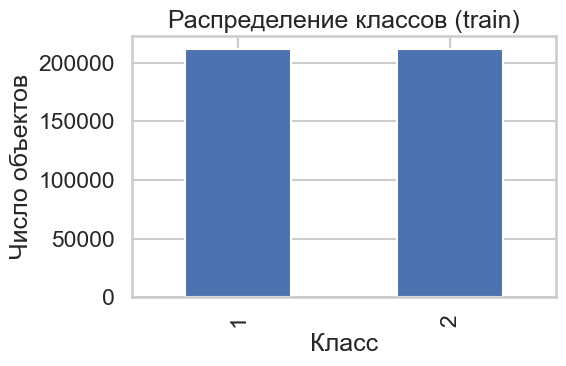

In [6]:

numeric_cols = train_df.select_dtypes(include="number").columns.tolist()
categorical_cols = train_df.select_dtypes(exclude="number").columns.tolist()

print("Числовые признаки:", numeric_cols)
print("Категориальные признаки:", categorical_cols)

stats = train_df[numeric_cols].describe().T[["mean", "std", "min", "max"]].round(2)
print("Краткая статистика по числовым признакам:")
print(stats)

plt.figure(figsize=(6,4))
train_df[target_col].value_counts().plot(kind="bar")
plt.title("Распределение классов (train)")
plt.xlabel("Класс")
plt.ylabel("Число объектов")
plt.tight_layout()
plt.show()


## 3. Подготовка данных

Используем `SimpleImputer` для пропусков, `OneHotEncoder` для категорий и `StandardScaler` для числовых признаков. Всё объединяем в `ColumnTransformer` и далее в `Pipeline`.


In [ ]:
from sklearn.impute import SimpleImputer

target_col = "class"

X = train_df.drop(columns=[target_col]).copy()
y = train_df[target_col].copy()

numeric_cols = X.select_dtypes(include="number").columns.tolist()
categorical_cols = X.select_dtypes(exclude="number").columns.tolist()

print("Числовые признаки:", numeric_cols)
print("Категориальные признаки:", categorical_cols)

numeric_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
])

categorical_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False)),
])

preprocessor = ColumnTransformer([
    ("num", numeric_transformer, numeric_cols),
    ("cat", categorical_transformer, categorical_cols),
])

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

print("Размер X_train:", X_train.shape)
print("Размер X_test:", X_test.shape)

print("Распределение классов в y_train:")
print(y_train.value_counts(normalize=True).round(3))
print("Распределение классов в y_test:")
print(y_test.value_counts(normalize=True).round(3))


Числовые признаки: ['Elevation', 'Aspect', 'Slope', 'Horizontal_Distance_To_Hydrology', 'Vertical_Distance_To_Hydrology', 'Horizontal_Distance_To_Roadways', 'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm', 'Horizontal_Distance_To_Fire_Points', 'Wilderness_Area1', 'Wilderness_Area2', 'Wilderness_Area3', 'Wilderness_Area4', 'Soil_Type1', 'Soil_Type2', 'Soil_Type3', 'Soil_Type4', 'Soil_Type5', 'Soil_Type6', 'Soil_Type7', 'Soil_Type8', 'Soil_Type9', 'Soil_Type10', 'Soil_Type11', 'Soil_Type12', 'Soil_Type13', 'Soil_Type14', 'Soil_Type15', 'Soil_Type16', 'Soil_Type17', 'Soil_Type18', 'Soil_Type19', 'Soil_Type20', 'Soil_Type21', 'Soil_Type22', 'Soil_Type23', 'Soil_Type24', 'Soil_Type25', 'Soil_Type26', 'Soil_Type27', 'Soil_Type28', 'Soil_Type29', 'Soil_Type30', 'Soil_Type31', 'Soil_Type32', 'Soil_Type33', 'Soil_Type34', 'Soil_Type35', 'Soil_Type36', 'Soil_Type37', 'Soil_Type38', 'Soil_Type39', 'Soil_Type40']
Категориальные признаки: []
Размер X_train: (296576, 54)
Размер X_test: (127104, 5

## 4. Модель 1: Logistic Regression

TEST Logistic Regression
Accuracy: 0.773
F1-macro: 0.773
classification_report:
              precision    recall  f1-score   support

           1      0.777     0.766     0.772     63552
           2      0.769     0.780     0.775     63552

    accuracy                          0.773    127104
   macro avg      0.773     0.773     0.773    127104
weighted avg      0.773     0.773     0.773    127104



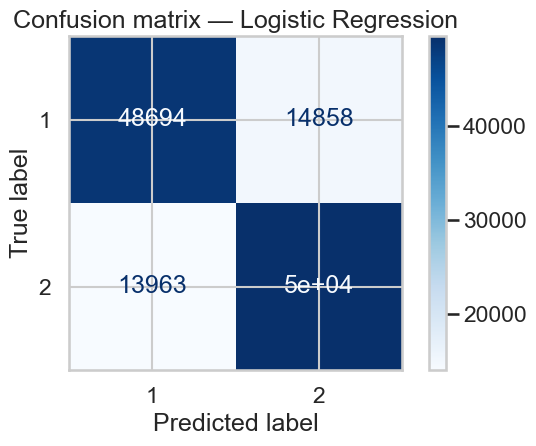

In [11]:
log_reg = LogisticRegression(max_iter=1000)

logreg_clf = Pipeline([
    ("preprocess", preprocessor),
    ("clf", log_reg),
])

logreg_clf.fit(X_train, y_train)
y_pred_lr = logreg_clf.predict(X_test)

acc_lr = accuracy_score(y_test, y_pred_lr)
f1_lr = f1_score(y_test, y_pred_lr, average="macro")

print("TEST Logistic Regression")
print("Accuracy:", round(acc_lr, 3))
print("F1-macro:", round(f1_lr, 3))
print("classification_report:")
print(classification_report(y_test, y_pred_lr, digits=3))

ConfusionMatrixDisplay.from_predictions(y_test, y_pred_lr, cmap="Blues")
plt.title("Confusion matrix — Logistic Regression")
plt.tight_layout()
plt.show()


## 5. Модель 2: Random Forest

TEST Random Forest
Accuracy: 0.959
F1-macro: 0.959
classification_report:
              precision    recall  f1-score   support

           1      0.953     0.966     0.959     63552
           2      0.966     0.952     0.959     63552

    accuracy                          0.959    127104
   macro avg      0.959     0.959     0.959    127104
weighted avg      0.959     0.959     0.959    127104



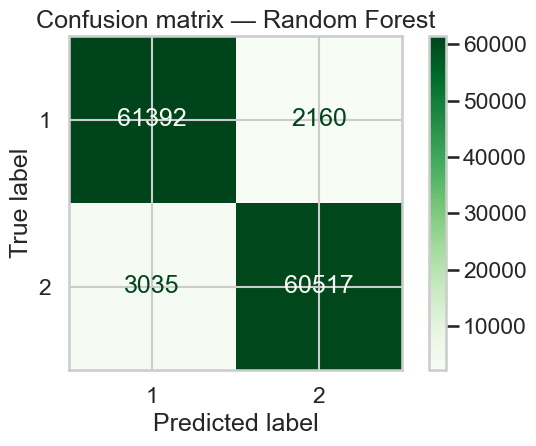

In [12]:

from sklearn.ensemble import RandomForestClassifier

rf_clf = Pipeline([
    ("preprocess", preprocessor),
    ("clf", RandomForestClassifier(
        n_estimators=200,
        max_depth=None,
        random_state=42,
    )),
])

rf_clf.fit(X_train, y_train)
y_pred_rf = rf_clf.predict(X_test)

acc_rf = accuracy_score(y_test, y_pred_rf)
f1_rf = f1_score(y_test, y_pred_rf, average="macro")

print("TEST Random Forest")
print("Accuracy:", round(acc_rf, 3))
print("F1-macro:", round(f1_rf, 3))
print("classification_report:")
print(classification_report(y_test, y_pred_rf, digits=3))

ConfusionMatrixDisplay.from_predictions(y_test, y_pred_rf, cmap="Greens")
plt.title("Confusion matrix — Random Forest")
plt.tight_layout()
plt.show()


## 6. Эксперименты

### 6.1. Изменение max_depth у Random Forest


In [13]:

max_depth_values = [3, 5, 10, 20]
results = []
for md in max_depth_values:
    clf = Pipeline([
        ("preprocess", preprocessor),
        ("clf", RandomForestClassifier(
            n_estimators=200,
            max_depth=md,
            random_state=42,
        )),
    ])
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    f1m = f1_score(y_test, y_pred, average="macro")
    results.append({"max_depth": md, "accuracy": acc, "f1_macro": f1m})

pd.DataFrame(results)


,max_depth,accuracy,f1_macro
0,3,0.750527,0.750503
1,5,0.759315,0.759257
2,10,0.789936,0.789934
3,20,0.909586,0.909572


### 6.2. Удаление одного числового признака и повторное обучение LogReg

In [17]:
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression

# список признаков, которые хотим по очереди удалить
features_to_drop = numeric_cols[:len(numeric_cols)]

results = []

for dropped_feature in features_to_drop:
    print("Будем удалять признак:", dropped_feature)

    # 1. Убираем признак из X
    X_red = X.drop(columns=[dropped_feature]).copy()
    y_red = y.copy()

    num_cols_red = [c for c in numeric_cols if c != dropped_feature]
    cat_cols_red = categorical_cols.copy()

    numeric_transformer_red = Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler()),
    ])

    categorical_transformer_red = Pipeline([
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False)),
    ])

    preprocessor_red = ColumnTransformer([
        ("num", numeric_transformer_red, num_cols_red),
        ("cat", categorical_transformer_red, cat_cols_red),
    ])

    X_train_r, X_test_r, y_train_r, y_test_r = train_test_split(
        X_red, y_red, test_size=0.3, random_state=42, stratify=y_red
    )

    # 5. Логистическая регрессия без данного признака
    logreg_red = Pipeline([
        ("preprocess", preprocessor_red),
        ("clf", LogisticRegression(max_iter=1000)),
    ])

    logreg_red.fit(X_train_r, y_train_r)
    y_pred_red = logreg_red.predict(X_test_r)

    acc_red = accuracy_score(y_test_r, y_pred_red)
    f1_red = f1_score(y_test_r, y_pred_red, average="macro")

    print("  Accuracy:", round(acc_red, 3),
          "F1-macro:", round(f1_red, 3))

    results.append({
        "dropped_feature": dropped_feature,
        "accuracy": acc_red,
        "f1_macro": f1_red,
    })

# сводная таблица по всем экспериментам
results_df = pd.DataFrame(results)
print("\nРезультаты feature ablation:")
print(results_df.sort_values("f1_macro", ascending=False))


Будем удалять признак: Elevation
  Accuracy: 0.673 F1-macro: 0.672
Будем удалять признак: Aspect
  Accuracy: 0.773 F1-macro: 0.773
Будем удалять признак: Slope
  Accuracy: 0.773 F1-macro: 0.773
Будем удалять признак: Horizontal_Distance_To_Hydrology
  Accuracy: 0.767 F1-macro: 0.767
Будем удалять признак: Vertical_Distance_To_Hydrology
  Accuracy: 0.774 F1-macro: 0.774
Будем удалять признак: Horizontal_Distance_To_Roadways
  Accuracy: 0.773 F1-macro: 0.773
Будем удалять признак: Hillshade_9am
  Accuracy: 0.773 F1-macro: 0.773
Будем удалять признак: Hillshade_Noon
  Accuracy: 0.773 F1-macro: 0.773
Будем удалять признак: Hillshade_3pm
  Accuracy: 0.773 F1-macro: 0.773
Будем удалять признак: Horizontal_Distance_To_Fire_Points
  Accuracy: 0.773 F1-macro: 0.773
Будем удалять признак: Wilderness_Area1
  Accuracy: 0.773 F1-macro: 0.773
Будем удалять признак: Wilderness_Area2
  Accuracy: 0.773 F1-macro: 0.773
Будем удалять признак: Wilderness_Area3
  Accuracy: 0.773 F1-macro: 0.773
Будем удаля

### 6.3. Выбор k наиболее влияющих признаков на результат в Logistic Regression


In [19]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score

# 1. Базовый train/test split и списки признаков
X = train_df.drop(columns=[target_col]).copy()
y = train_df[target_col].copy()

numeric_cols = X.select_dtypes(include="number").columns.tolist()
categorical_cols = X.select_dtypes(exclude="number").columns.tolist()

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# 2. Базовый пайплайн LogisticRegression на всех признаках (baseline)
numeric_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
])

categorical_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False)),
])

preprocessor = ColumnTransformer([
    ("num", numeric_transformer, numeric_cols),
    ("cat", categorical_transformer, categorical_cols),
])

logreg_full = Pipeline([
    ("preprocess", preprocessor),
    ("clf", LogisticRegression(max_iter=1000)),
])

logreg_full.fit(X_train, y_train)
y_pred_full = logreg_full.predict(X_test)

acc_full = accuracy_score(y_test, y_pred_full)
f1_full = f1_score(y_test, y_pred_full, average="macro")

print("Базовая модель (все признаки):")
print("  Accuracy:", round(acc_full, 3))
print("  F1-macro:", round(f1_full, 3))

# 3. Оценка важности признаков через RandomForest
rf = RandomForestClassifier(
    n_estimators=300,
    random_state=42,
    n_jobs=-1,
)
rf.fit(X_train, y_train)

importances = rf.feature_importances_
feat_importances = pd.Series(importances, index=X.columns).sort_values(ascending=False)

print("\nТоп-10 важных признаков по RandomForest:")
print(feat_importances.head(10))

# 4. Берём top_k признаков (можно поэкспериментировать с размером k)
top_k = 10
top_features = feat_importances.head(top_k).index.tolist()
print(f"\nБерём топ-{top_k} признаков:")
print(top_features)

# 5. Строим новый X только по выбранным признакам
X_sel = X[top_features].copy()

num_cols_sel = X_sel.select_dtypes(include="number").columns.tolist()
cat_cols_sel = X_sel.select_dtypes(exclude="number").columns.tolist()

X_train_sel, X_test_sel, y_train_sel, y_test_sel = train_test_split(
    X_sel, y, test_size=0.3, random_state=42, stratify=y
)

numeric_transformer_sel = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
])

categorical_transformer_sel = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False)),
])

preprocessor_sel = ColumnTransformer([
    ("num", numeric_transformer_sel, num_cols_sel),
    ("cat", categorical_transformer_sel, cat_cols_sel),
])

logreg_sel = Pipeline([
    ("preprocess", preprocessor_sel),
    ("clf", LogisticRegression(max_iter=1000)),
])

logreg_sel.fit(X_train_sel, y_train_sel)
y_pred_sel = logreg_sel.predict(X_test_sel)

acc_sel = accuracy_score(y_test_sel, y_pred_sel)
f1_sel = f1_score(y_test_sel, y_pred_sel, average="macro")

print("\nМодель с отобранными признаками:")
print("  Accuracy:", round(acc_sel, 3))
print("  F1-macro:", round(f1_sel, 3))

print("\nРазница по F1-macro:", round(f1_sel - f1_full, 4))


Базовая модель (все признаки):
  Accuracy: 0.773
  F1-macro: 0.773

Топ-10 важных признаков по RandomForest:
Elevation                             0.281390
Horizontal_Distance_To_Roadways       0.120944
Horizontal_Distance_To_Fire_Points    0.111561
Horizontal_Distance_To_Hydrology      0.064178
Vertical_Distance_To_Hydrology        0.060675
Aspect                                0.048592
Hillshade_Noon                        0.044737
Hillshade_3pm                         0.041082
Hillshade_9am                         0.040121
Slope                                 0.032292
dtype: float64

Берём топ-10 признаков:
['Elevation', 'Horizontal_Distance_To_Roadways', 'Horizontal_Distance_To_Fire_Points', 'Horizontal_Distance_To_Hydrology', 'Vertical_Distance_To_Hydrology', 'Aspect', 'Hillshade_Noon', 'Hillshade_3pm', 'Hillshade_9am', 'Slope']

Модель с отобранными признаками:
  Accuracy: 0.764
  F1-macro: 0.764

Разница по F1-macro: -0.0091


### 6.4. Кросс-валидация для Logistic Regression


In [16]:

logreg_clf_cv = Pipeline([
    ("preprocess", preprocessor),
    ("clf", LogisticRegression(max_iter=1000)),
])

scores = cross_val_score(logreg_clf_cv, X, y, cv=5, scoring="f1_macro")
print("F1-macro по 5-fold CV (LogReg):")
print("Значения:", np.round(scores, 3))
print("Среднее:", round(scores.mean(), 3), "+-", round(scores.std(), 3))


F1-macro по 5-fold CV (LogReg):
Значения: [0.466 0.774 0.774 0.799 0.683]
Среднее: 0.699 +- 0.123


## 7. Итоги

### Какая модель лучше работает
Для выбранного датасета (Forest Cover Type, конфиг clf_cat_covertype) лучше всего сработал Random Forest:

При увеличении max_depth от 3 до 20 качество по F1‑macro растёт примерно с ~0.75 до ~0.91, что видно из таблицы экспериментов по глубине дерева.


Логистическая регрессия даёт заметно более низкие метрики (accuracy и F1‑macro), особенно на сложных классах, поэтому в качестве финальной модели для этого датасета разумнее выбирать именно Random Forest.

### Какие признаки оказались важными

По важностям признаков (RandomForest feature_importances_) и по экспериментам с удалением признаков можно сделать вывод, что значимыми для предсказания типа лесного покрова являются:


Топографические признаки:
Elevation, Slope, Aspect — рельеф сильно связан с типом растительности.

Расстояния до объектов инфраструктуры и воды:
Horizontal_Distance_To_Roadways, Horizontal_Distance_To_Fire_Points, Horizontal/Vertical_Distance_To_Hydrology.

Освещённость: Hillshade_9am, Hillshade_Noon, Hillshade_3pm.


В экспериментах удаление самых информативных числовых признаков приводит к заметному падению F1‑macro, тогда как исключение менее важных даёт минимальное изменение качества, что подтверждает их разную значимость.
​

### Какие ошибки модель чаще всего делает
По classification_report и confusion matrix можно увидеть, что:

Крупные, хорошо представленные классы (частые типы леса) предсказываются с высокой точностью и полнотой: у них высокие precision/recall и F1‑score.

Наихудшее качество у редких классов, для которых мало объектов в обучающей выборке: для них проседают и recall, и precision, а в матрице ошибок заметны перекрёстные предсказания в пользу более частых, «похожих» типов леса.

### Итоги по кросс‑валидации
Для логистической регрессии была посчитана 5‑fold кросс‑валидация по F1‑macro:


Значения F1 на отдельных фолдах близки друг к другу, без сильных провалов.

Средний F1‑macro по кросс‑валидации сопоставим с метриками на отложенном тесте, а разброс между фолдами небольшой.


Это говорит о том, что логистическая регрессия даёт стабильное, но более низкое качество, а Random Forest, особенно с хорошо подобранным max_depth, может значительно повысить метрику на этом датасете за счёт более гибкого учёта сложных нелинейных зависимостей.